# Predicting academic achievement from inattention (SNAP)

Arvid Lundervold, 20-Sep-2017

A.J. Lundervold, T. Bøe, A. Lundervold. *Inattention in primary school is not good for your future school achievement - a pattern classification study*. In rev.

*Objective.* Inattention in childhood has been associated with academic problems later in life. The contribution of specific aspects of inattentive behaviour is, however, less known. We investigated the importance of primary teacher reports on nine aspects of inattentive behaviour in predicting future academic achievement.<br>
*Methods*. Primary school teachers of 2397 children (7 - 9 years) rated nine items reflecting different aspects of inattentive behaviour. Academic achievement scores were available from an official school register about ten years later. All scores were at a categorical level. Two multivariate statistical methods (in R), a multinominal logistic regression analysis and a Classification and Regression Trees (CART) analysis, were included to predict high school academic achievement from the nine inattention items, gender and their primary school class level (grade) when evaluated by their teachers
(2nd to 4th grade, 7 - 9 years).<br>
*Results.* Problems related to sustained attention and distractibility were found to be important predictors of low level of academic achievement in high school. Overall, inattention was rated as more severe in boys, who also obtained lower achievement scores at high school than girls. However, if reported to have no problems related to sustained attention and distractibility in the 4th primary school class level, the percentage of boys with the highest level of the achievement score was as high as in girls (> 40%).<br>
*Conclusion.* Primary school teachers’ reports of problems related to sustained attention and distractibility were strong predictors of low academic achievement in high school. Identification and follow-up procedures of primary school children showing this pattern of inattentive behaviour should be prioritised to prevent future academic and occupational failure.

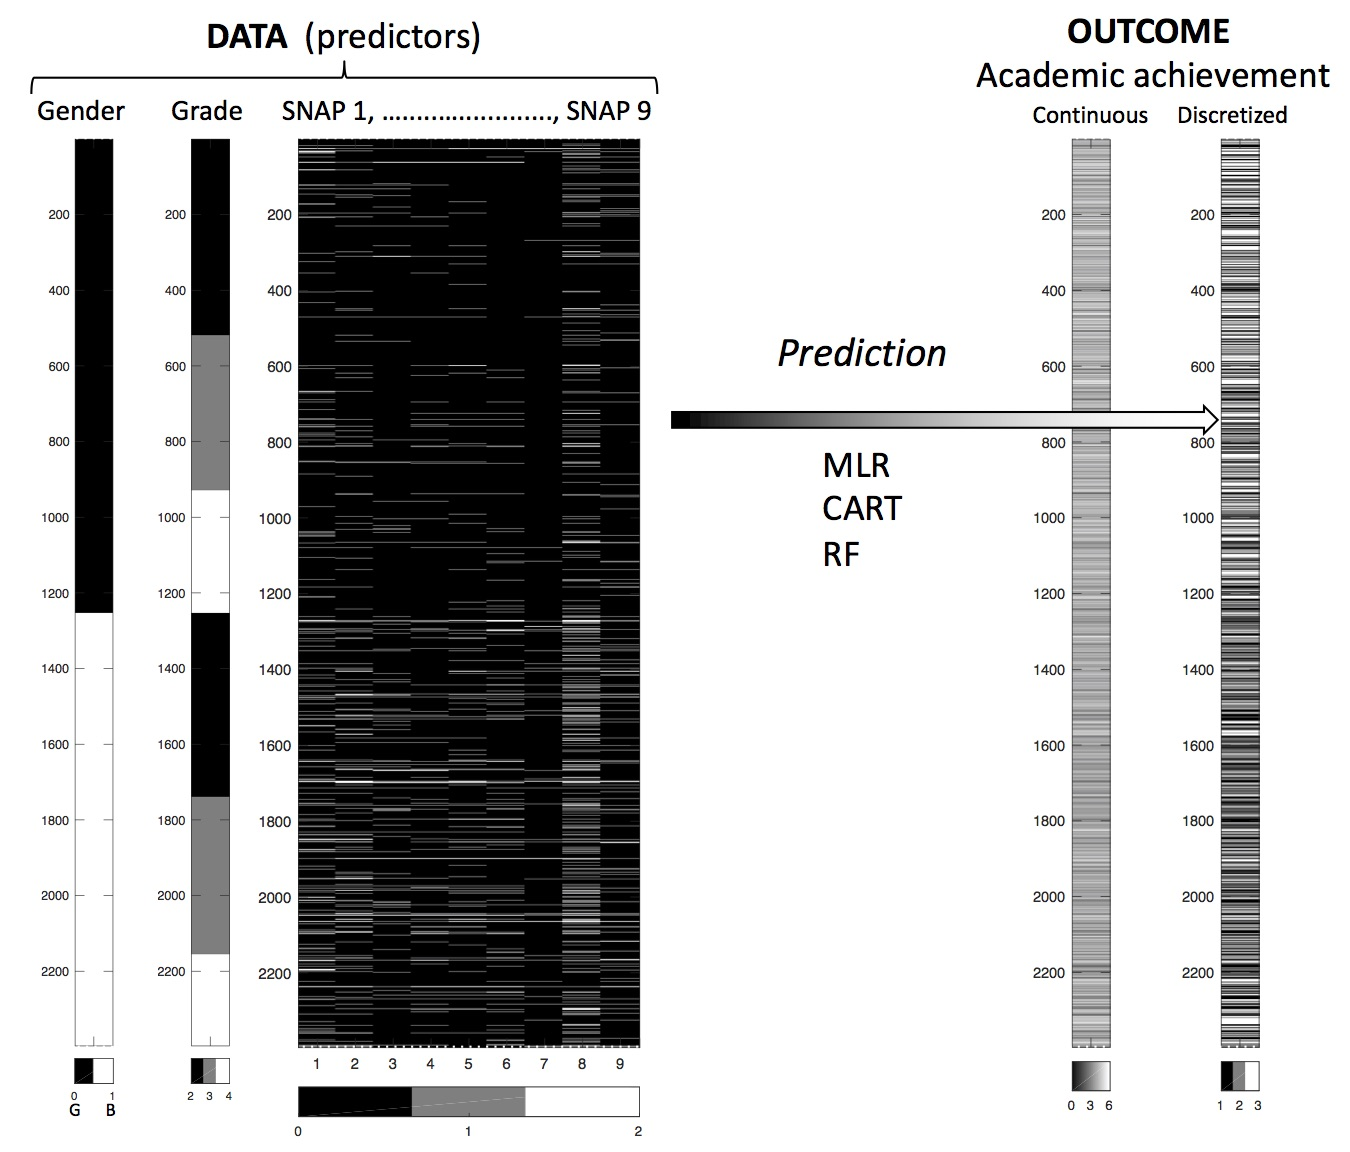

In [80]:
from IPython.display import Image
Image("../images/Data_to_classes_pptx.jpg")

## Prepare

In [81]:
%matplotlib inline

import os
import os.path as op
import numpy as np
import pandas as pd
import nibabel as nib
import scipy
import seaborn as sns
import math
import csv
from nilearn import image
from nilearn import plotting
from matplotlib import pyplot as plt
from nilearn.image.image import mean_img
from sklearn.cluster import KMeans
from nilearn.masking import apply_mask
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
from io import StringIO

import nilearn
import sklearn
import matplotlib
import pydicom  # pip install git+https://github.com/pydicom/pydicom.git
import xgboost as xgb

# plt.style.use('ggplot')
# plt.style.use('classic')
# plt.style.use('seaborn-paper')
# plt.style.use('seaborn')

print('numpy: %s' % np.__version__)
print('pandas: %s' % pd.__version__)
print('nibabel: %s' % nib.__version__)
print('scipy: %s' % scipy.__version__)
print('nilearn: %s' % nilearn.__version__)
print('matplotlib: %s' % matplotlib.__version__)
print('sklearn: %s' % sklearn.__version__)
print('pydicom: %s' % pydicom.__version__)
print('seaborn: %s' % sns.__version__)
print('xgboost: %s' % xgb.__version__)

numpy: 1.11.3
pandas: 0.20.3
nibabel: 2.1.0
scipy: 0.19.1
nilearn: 0.3.1
matplotlib: 2.0.2
sklearn: 0.19.0
pydicom: 1.0.0a1
seaborn: 0.8.1
xgboost: 0.6


In [82]:
# Relevant files

fnD3 = "../data/inattention_nomiss_2397x12_snap_is_0_1_2.csv" 
fnC = "../data/inattention_nomiss_2397x12_snap_is_0_1_2_outcome_is_L_M_H.csv"
fnD = "../data/inattention_nomiss_2397x12_snap_is_N_S_C_outcome_is_L_M_H.csv"
fnE = "../data/inattention_nomiss_2397x12_snap_is_0_1_2_outcome_is_0_1_2.csv"


In [83]:
# The inattention_nomiss_2397x12_snap_is_0_1_2_outcome_is_L_M_H.csv data

dfC = pd.read_csv(fnC)
dfC.head()

,gender,grade,snap1,snap2,snap3,snap4,snap5,snap6,snap7,snap8,snap9,averBinned
0,1,2,1,1,1,1,1,1,1,1,1,H
1,1,2,1,1,2,1,1,1,1,1,1,L
2,1,2,1,1,1,1,1,1,1,1,1,M
3,1,2,1,1,1,1,1,1,1,1,1,M
4,1,2,1,1,1,1,1,1,1,1,1,M


In [84]:
dfC.tail()

,gender,grade,snap1,snap2,snap3,snap4,snap5,snap6,snap7,snap8,snap9,averBinned
2392,0,4,0,2,2,1,1,1,1,2,1,L
2393,0,4,2,2,2,2,1,2,1,2,1,M
2394,0,4,2,1,1,1,1,1,1,1,1,M
2395,0,4,2,2,1,1,1,1,2,2,2,M
2396,0,4,2,1,1,1,1,1,1,1,1,L


In [85]:
print(dfC.info())
print(dfC.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2397 entries, 0 to 2396
Data columns (total 12 columns):
gender        2397 non-null int64
grade         2397 non-null int64
snap1         2397 non-null int64
snap2         2397 non-null int64
snap3         2397 non-null int64
snap4         2397 non-null int64
snap5         2397 non-null int64
snap6         2397 non-null int64
snap7         2397 non-null int64
snap8         2397 non-null int64
snap9         2397 non-null int64
averBinned    2397 non-null object
dtypes: int64(11), object(1)
memory usage: 224.8+ KB
None
            gender        grade        snap1        snap2        snap3  \
count  2397.000000  2397.000000  2397.000000  2397.000000  2397.000000   
mean      0.523988     2.813934     1.094285     1.075094     1.069253   
std       0.499528     0.787797     0.351892     0.333497     0.277498   
min       0.000000     2.000000     0.000000     0.000000     0.000000   
25%       0.000000     2.000000     1.000000     1.00000

## Random Forest for SNAP inattention data

Random forests are very good in that it is an ensemble learning method used for classification and regression. It uses multiple models for better performance that just using a single tree model. In addition because many sample are selected in the process a measure of variable importance can be obtain and this approach can be used for model selection and can be particularly useful when forward/backward stepwise selection is not appropriate and when working with an extremely high number of candidate variables that need to be reduced.

randomForest - implements Breiman’s random forest algorithm (based on Breiman and Cutler’s original Fortran code) for classification and regression. It can also be used in unsupervised mode for assessing proximities among data points.

## Feature importance¶

Testing for xgboost
https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/ 
https://datascience.stackexchange.com/questions/10943/why-is-xgboost-so-much-faster-than-sklearn-gradientboostingclassifier

```python
https://archive.ics.uci.edu/ml/datasets/pima+indians+diabetes   
    
1. Number of times pregnant 
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test 
3. Diastolic blood pressure (mm Hg) 
4. Triceps skin fold thickness (mm) 
5. 2-Hour serum insulin (mu U/ml) 
6. Body mass index (weight in kg/(height in m)^2) 
7. Diabetes pedigree function 
8. Age (years) 
9. Class variable (0 or 1) 
```

[ 0.089701    0.17109634  0.08139535  0.04651163  0.10465116  0.2026578
  0.1627907   0.14119601]


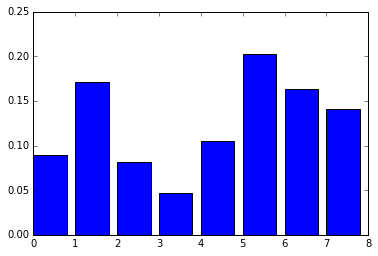

In [95]:
# We can then import xgboost and run a small example.

# plot feature importance manually
from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot

# load data
# dataset = loadtxt('../data/pima-indians-diabetes.csv', delimiter=",")
# ~/Dropbox/Arvid/MachineLearning/Data/pima-indians-diabetes.csv
url='https://www.dropbox.com/s/zx0nj33f7gb9sse/pima-indians-diabetes.csv?dl=1'
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataset = pd.read_csv(url, header=None, names = names)

# split data into X and y
X = dataset.iloc[:,0:8]
y = dataset.iloc[:,8]

# fit model no training data
model = XGBClassifier()
model.fit(X, y)

# feature importance
print(model.feature_importances_)

# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

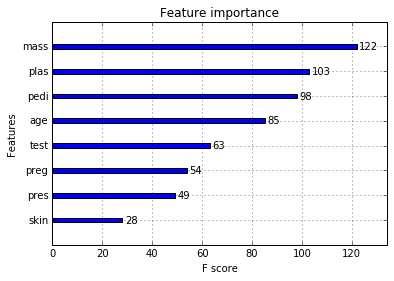

In [96]:
# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

# load data
url='https://www.dropbox.com/s/zx0nj33f7gb9sse/pima-indians-diabetes.csv?dl=1'
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataset = pd.read_csv(url, header=None, names = names)

# split data into X and y
X = dataset.iloc[:,0:8]
y = dataset.iloc[:,8]

# fit model no training data
model = XGBClassifier()
model.fit(X, y)

# plot feature importance
plot_importance(model)
pyplot.show()

**Select predictors X and outcome y and build a RandomForestClassifier**

In [121]:
X = dfC.loc[:, dfC.columns != 'averBinned'] 
y = dfC.loc[:, 'averBinned']
print(X.shape)
print(X.columns)

(2397, 11)
Index(['gender', 'grade', 'snap1', 'snap2', 'snap3', 'snap4', 'snap5', 'snap6',
       'snap7', 'snap8', 'snap9'],
      dtype='object')


In [122]:
# Build a forest and compute the feature importances
# forest = ExtraTreesClassifier(n_estimators=50000, max_features=None, random_state=0)
# Alternatively, a Random Forest classifier could be used to assess feature importance, i.e.
forest = RandomForestClassifier(n_estimators=50000, max_features=None, random_state=0)
forest.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50000, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

**Compute and display the feature importance from the forest**

Feature ranking:
1. feature 3 [snap2] (0.134945)
2. feature 1 [grade] (0.123275)
3. feature 2 [snap1] (0.106121)
4. feature 10 [snap9] (0.103191)
5. feature 9 [snap8] (0.099341)
6. feature 6 [snap5] (0.084845)
7. feature 7 [snap6] (0.078192)
8. feature 4 [snap3] (0.077526)
9. feature 0 [gender] (0.073147)
10. feature 5 [snap4] (0.072113)
11. feature 8 [snap7] (0.047304)


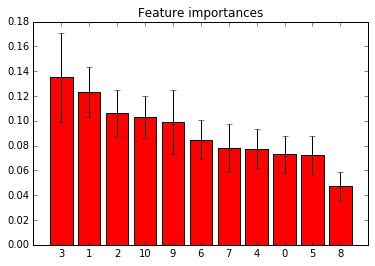

Top 5 feature ranking:


,connection,feature no.,importance
1,snap2,3,0.134945
2,grade,1,0.123275
3,snap1,2,0.106121
4,snap9,10,0.103191
5,snap8,9,0.099341


In [123]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

n_ = X.shape[1]
#n_ = 10
for f in range(n_):
    print("%d. feature %d [%s] (%f)" % (f+1, indices[f], X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()


print("Top 5 feature ranking:")

top = 5
top5 = indices[range(top)]  # Feature importances with Random Forest

X5 = X.iloc[:, top5]
c1 = pd.DataFrame(X.columns[top5], index = list(range(1, top+1)), columns = ['connection'])
c2 = pd.DataFrame(indices[range(top)], index = list(range(1, top+1)), columns = ['feature no.'])
c3 = pd.DataFrame(importances[indices[range(top)]], index = list(range(1, top+1)), columns = ['importance'])
pd.concat([c1, c2, c3], axis=1)

Index(['snap2', 'grade', 'snap1', 'snap9', 'snap8', 'snap5', 'snap6', 'snap3',
       'gender', 'snap4', 'snap7'],
      dtype='object')


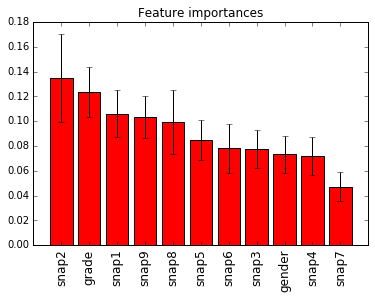

In [125]:
# Plot the top ranked feature importances of the forest

fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

top_n = 11
topn = indices[range(top_n)]  # Feature importances with Random Forest

Xn = X.iloc[:, topn]

print(Xn.columns)
plt.figure()
plt.title("Feature importances")
plt.bar(range(Xn.shape[1]), importances[topn],
       color="r", yerr=std[topn], align="center")
labels = Xn.columns
#  plt.xticks(range(Xn.shape[1]), topn, labels, rotation = 45, fontsize=18)
plt.xticks(range(top_n), labels, rotation = 90, fontsize=12)
plt.xlim([-1, Xn.shape[1]])
thisfig_ = '../manus/Figs/random_forest_feature_importances_top5.pdf'
#plt.savefig(thisfig_, bbox_inches='tight')
plt.show()

## Organizing data as X and y before classification

In [128]:
# Previously saved the top 5 important connections and 
# corresponding ReSQ score (Ymem / Nmem) to csv file

# from sklearn.preprocessing import LabelEncoder

# dfX5Y = pd.read_csv('../results/02_X5Y.csv', sep=',')
# print(dfX5Y.info())
# print(dfX5Y.describe())
# dfX5Y

# Featuer importance XGBoost:
# X = df.loc[:, ['CC_Mid_Anterior_w3', 'BrainSegVol-to-eTIV_w3', 'CSF_w2']] # Top three important features
# Featuer importance RF (Strrop_3):
#X = dfC.loc[:, ['BrainSegVol-to-eTIV_w3', 'CC_Mid_Anterior_w3', 'ic04-ic02']] # Top three important features
# Featuer importance RF predicrting Stroop_1_R_3:
# X = df.loc[:, ['ic09-ic06', 'ic10-ic01', 'ic05-ic03']] # Top three important features
# Featuer importance RF predicrting Stroop_2_R_3:
# X = df.loc[:, ['WM-hypointensities_w3', 'ic17-ic04', 'Left-vessel_w3']] # Top three important features
# X = df.loc[:, ['BrainSegVol-to-eTIV_w3', 'ic04-ic02']] # Two important features
# X = df.loc[:, ['BrainSegVol-to-eTIV_w3', 'CC_Mid_Anterior_w3']] # Top two important features
#Y = df.loc[:, ['Stroop_3_cat']]


# Xp = dfC.loc[:, ['snap2', 'grade', 'snap8', 'gender']]
Xp = dfC.loc[:, ['snap2', 'grade', 'snap1']]
# Xp = dfC.loc[:, ['gender', 'grade']]
# Xp = X
#y = y.as_matrix().ravel()
print(np.unique(y))
Xp.columns

['H' 'L' 'M']


Index(['snap2', 'grade', 'snap1'], dtype='object')

## Classification

In [129]:
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import preprocessing

# X = dfX5Y.loc[:, dfX5Y.columns != 'grp']      # Top five important connections
# X = dfX5Y.loc[:, ['ic09-ic02', 'ic04-ic01']]   # Top two important connections
# X = df.loc[:, ['LatVent_w2', 'LatVent_w3', 'ic09-ic02', 'ic04-ic01']]
# X = df.loc[:, ['LatVent_w3', 'ic09-ic02']]
# X = df.loc[:, ['LatVent_w2', 'LatVent_w3']]
# Y = df.loc[:, ['Stroop_3_cat']]

# X = df.loc[:, ['BrainSegVol-to-eTIV_w3', 'CC_Mid_Anterior_w3', 'ic04-ic02']]
# Y = df.loc[:, ['Stroop_3_cat']]
# y = Y.as_matrix().ravel()

rs = 42 # random_state (42)
hls = 3 # MLP hidden layer size (3 or 4)
# https://stackoverflow.com/questions/37659970/how-does-sklearn-compute-the-precision-score-metric
myaverage = 'weighted' # For multilabel classification  'micro', 'macro', 'samples', 'weighted'
# see: https://stackoverflow.com/questions/37659970/how-does-sklearn-compute-the-precision-score-metric

# http://scikit-learn.org/stable/modules/neural_networks_supervised.html
# Class MLPClassifier implements a multi-layer perceptron (MLP) algorithm that 
# trains using Backpropagation.

# So what about size of the hidden layer(s)--how many neurons? 
# There are some empirically-derived rules-of-thumb, of these, the most 
# commonly relied on is 'the optimal size of the hidden layer is usually 
# between the size of the input and size of the output layers'. 
# Jeff Heaton, author of Introduction to Neural Networks in Java offers a few more.
#
# In sum, for most problems, one could probably get decent performance (even without 
# a second optimization step) by setting the hidden layer configuration using j
# ust two rules: 
#  (i) number of hidden layers equals one; and 
# (ii) the number of neurons in that layer is the mean of the neurons in the 
#      input and output layers.


# Compute the precision
# The precision is the ratio tp / (tp + fp) where tp is the number of true positives and 
# fp the number of false positives. The precision is intuitively the ability of the 
# classifier not to label as positive a sample that is negative.

# Compute the recall
# The recall is the ratio tp / (tp + fn) where tp is the number of true positives and 
# fn the number of false negatives. The recall is intuitively the ability of the 
# classifier to find all the positive samples.

# Compute the F1 score, also known as balanced F-score or F-measure
# The F1 score can be interpreted as a weighted average of the precision and recall, 
# where an F1 score reaches its best value at 1 and worst score at 0. 
# The relative contribution of precision and recall to the F1 score are equal. 
# The formula for the F1 score is:
#    F1 = 2 * (precision * recall) / (precision + recall)
# In the multi-class and multi-label case, this is the weighted average of the F1 score of each class.

pipe_clf1 = Pipeline([
    ('scl', StandardScaler()),
    #('pca', PCA(n_components=2)),
    ('clf1', LogisticRegression(C=1., solver='saga', n_jobs=1, 
                                multi_class='multinomial', random_state=rs))])

pipe_clf2 = Pipeline([
    ('scl', StandardScaler()),
    #('pca', PCA(n_components=2)),
    ('clf2', MLPClassifier(hidden_layer_sizes=(hls, ),   # =(100, )  ; =(4, )
                          activation='relu', solver='adam',
                          alpha=0.0001, batch_size='auto', learning_rate='constant',
                          learning_rate_init=0.001, power_t=0.5, max_iter=5000,
                          shuffle=True, random_state=rs, tol=0.0001, verbose=False,
                          warm_start=False, momentum=0.9, nesterovs_momentum=True,
                          early_stopping=False, validation_fraction=0.1,
                          beta_1=0.9, beta_2=0.999, epsilon=1e-08))])

# pipe_clf3 = Pipeline([
#     ('scl', StandardScaler()),
#     #('pca', PCA(n_components=2)),
#     ('clf3', RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None,
#                                   min_samples_split=2, min_samples_leaf=1,
#                                   min_weight_fraction_leaf=0.0, max_features='auto',
#                                   max_leaf_nodes=None,     #  min_impurity_split=1e-07,
#                                   bootstrap=True, oob_score=False, n_jobs=1,
#                                   random_state=rs, verbose=0, warm_start=False,
#                                   class_weight=None))])
# pipe_clf3 = Pipeline([
#     ('scl', StandardScaler()),
#     #('pca', PCA(n_components=2)),
#     ('clf3', GradientBoostingClassifier(init=None, learning_rate=0.05, loss='deviance',
#                                         max_depth=None, max_features=None, max_leaf_nodes=None,
#                                         min_samples_leaf=1, min_samples_split=2,
#                                         min_weight_fraction_leaf=0.0, n_estimators=100,
#                                         presort='auto', random_state=rs, subsample=1.0, verbose=0,
#                                         warm_start=False)
pipe_clf3 = Pipeline([
    ('scl', StandardScaler()),
    #('pca', PCA(n_components=2)),
    ('clf3', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
                           gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
                           min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
                           objective='multi:softprob', reg_alpha=0, reg_lambda=1,
                           scale_pos_weight=1, seed=rs, silent=True, subsample=1))])
     
pipe_clf4 = Pipeline([
    ('scl', StandardScaler()),
    #('pca', PCA(n_components=2)),
    ('clf4', SVC(C=1.0, probability=True, random_state=rs))])
#    ('clf4', SVC(C=1.0, random_state=rs))])
    
pipe_clf5 = Pipeline([
    ('scl', StandardScaler()),
    #('pca', PCA(n_components=2)),
    ('clf5', KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='kd_tree', 
                           leaf_size=30, p=2, metric='minkowski', 
                           metric_params=None, n_jobs=1))])

pipe_clf_vote =  Pipeline([
#    ('scl', StandardScaler()),
    ('clf_vote', VotingClassifier(
        estimators=[('lr', pipe_clf1), 
                 ('mlp', pipe_clf2),
                 ('rf', pipe_clf3),
                 ('svc', pipe_clf4),
                 ('knn', pipe_clf5)],
     voting = 'soft'))])
#     voting = 'hard'))])

scores1_acc, scores2_acc, scores3_acc, scores4_acc, scores5_acc, scores_vote_acc = [], [], [], [], [], []
scores1_pre, scores2_pre, scores3_pre, scores4_pre, scores5_pre, scores_vote_pre = [], [], [], [], [], []
scores1_rec, scores2_rec, scores3_rec, scores4_rec, scores5_rec, scores_vote_rec = [], [], [], [], [], []
scores1_f1, scores2_f1, scores3_f1, scores4_f1, scores5_f1, scores_vote_f1 = [], [], [], [], [], []

n_splits = 10  # k=10
# n_splits = X.shape[0]   # i.e.  Leave One Out strategy
# for train_index, test_index in LeaveOneOut.split(X):

   
k=1
for train_index, test_index in \
StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rs).split(X,y):
    print("Fold number:", k)
    #print("\nTRUE class:\n", list(y[test_index]))
    X_train, X_test = Xp.iloc[train_index], Xp.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    
    #clf1 = LogisticRegression
    print(" - LogisticRegression")
    pipe_clf1.fit(X_train, y_train)
    scores1_acc.append(accuracy_score(y_test, pipe_clf1.predict(X_test)))
    scores1_pre.append(precision_score(y_test, pipe_clf1.predict(X_test), average=myaverage))
    scores1_rec.append(recall_score(y_test, pipe_clf1.predict(X_test), average=myaverage))
    scores1_f1.append(f1_score(y_test, pipe_clf1.predict(X_test), average=myaverage))
    print('    Precision: %.2f' % (precision_score(y_test, pipe_clf1.predict(X_test), average=myaverage)))
    print('    Recall: %.2f' % (recall_score(y_test, pipe_clf1.predict(X_test), average=myaverage)))
    #print("LR predicted:\n", list(pipe_clf1.predict(X_test)))
    
    #clf2 = MLPClassifier
    print(" - MLPClassifier")
    pipe_clf2.fit(X_train, y_train)
    scores2_acc.append(accuracy_score(y_test, pipe_clf2.predict(X_test)))
    scores2_pre.append(precision_score(y_test, pipe_clf2.predict(X_test), average=myaverage))
    scores2_rec.append(recall_score(y_test, pipe_clf2.predict(X_test), average=myaverage))
    scores2_f1.append(f1_score(y_test, pipe_clf2.predict(X_test), average=myaverage))
    print('    Precision: %.2f' % (precision_score(y_test, pipe_clf2.predict(X_test), average=myaverage)))
    print('    Recall: %.2f' % (recall_score(y_test, pipe_clf2.predict(X_test), average=myaverage)))
    #print("MLP predicted:\n", list(pipe_clf2.predict(X_test)))
    
    #clf3 = RandomForestClassifier
    #print(" - RandomForestClassifier")
    #clf3 = XGBoost
    print(" - XGBoost")
    pipe_clf3.fit(X_train, y_train)
    scores3_acc.append(accuracy_score(y_test, pipe_clf3.predict(X_test)))
    scores3_pre.append(precision_score(y_test, pipe_clf3.predict(X_test), average=myaverage))
    scores3_rec.append(recall_score(y_test, pipe_clf3.predict(X_test), average=myaverage))
    scores3_f1.append(f1_score(y_test, pipe_clf3.predict(X_test), average=myaverage))
    print('    Precision: %.2f' % (precision_score(y_test, pipe_clf3.predict(X_test), average=myaverage)))
    print('    Recall: %.2f' % (recall_score(y_test, pipe_clf3.predict(X_test), average=myaverage)))
    #print("RF predicted:\n", list(pipe_clf3.predict(X_test)))
    #print("XGB predicted:\n", list(pipe_clf3.predict(X_test)))
    
    #clf4 = svm.SVC()
    print(" - svm/SVC")
    pipe_clf4.fit(X_train, y_train)
    scores4_acc.append(accuracy_score(y_test, pipe_clf4.predict(X_test)))
    scores4_pre.append(precision_score(y_test, pipe_clf4.predict(X_test), average=myaverage))
    scores4_rec.append(recall_score(y_test, pipe_clf4.predict(X_test), average=myaverage))
    scores4_f1.append(f1_score(y_test, pipe_clf4.predict(X_test), average=myaverage))
    print('    Precision: %.2f' % (precision_score(y_test, pipe_clf4.predict(X_test), average=myaverage)))
    print('    Recall: %.2f' % (recall_score(y_test, pipe_clf4.predict(X_test), average=myaverage)))
    #print("SVM predicted:\n", list(pipe_clf4.predict(X_test)))
    
    #clf5 = KNeighborsClassifier
    print(" - KNN")
    pipe_clf5.fit(X_train, y_train)
    scores5_acc.append(accuracy_score(y_test, pipe_clf5.predict(X_test)))
    scores5_pre.append(precision_score(y_test, pipe_clf5.predict(X_test), average=myaverage))
    scores5_rec.append(recall_score(y_test, pipe_clf5.predict(X_test), average=myaverage))
    scores5_f1.append(f1_score(y_test, pipe_clf5.predict(X_test), average=myaverage))
    #print("KNN predicted:\n", list(pipe_clf5.predict(X_test)))
    
    #clf_vote = VotingClassifier
    print(" - VotingClassifier")
    pipe_clf_vote.fit(X_train, y_train)
    scores_vote_acc.append(accuracy_score(y_test, pipe_clf_vote.predict(X_test)))
    scores_vote_pre.append(precision_score(y_test, pipe_clf_vote.predict(X_test), average=myaverage))
    scores_vote_rec.append(recall_score(y_test, pipe_clf_vote.predict(X_test), average=myaverage))
    scores_vote_f1.append(f1_score(y_test, pipe_clf_vote.predict(X_test), average=myaverage))
    print('    Precision: %.2f' % (precision_score(y_test, pipe_clf_vote.predict(X_test), average=myaverage)))
    print('    Recall: %.2f' % (recall_score(y_test, pipe_clf_vote.predict(X_test), average=myaverage)))
    k=k+1
    
print('\nPredictors:')
print('Xp.columns = %s' % list(Xp.columns))

print('\nOutcome:')
#print(pd.qcut(df['Stroop_3_R_3'], 3).head(0))
print(np.unique(y))

print('\nSome hyperparameters:')
print("MLP hidden_layer_size = %d" % (hls))
print("random_state = %d" % (rs))
print("score average = '%s'" % (myaverage))

print("\nLR : CV accuracy = %.3f +-%.3f (k=%d)" % (np.mean(scores1_acc), np.std(scores1_acc), n_splits))
print("MLP: CV accuracy = %.3f +-%.3f (k=%d)" % (np.mean(scores2_acc), np.std(scores2_acc), n_splits))
# print("RF : CV accuracy = %.3f +-%.3f (k=%d)" % (np.mean(scores3_acc), np.std(scores3_acc), n_splits))
print("XGB : CV accuracy = %.3f +-%.3f (k=%d)" % (np.mean(scores3_acc), np.std(scores3_acc), n_splits))
print("SVM: CV accuracy = %.3f +-%.3f (k=%d)" % (np.mean(scores4_acc), np.std(scores4_acc), n_splits))
print("KNN: CV accuracy = %.3f +-%.3f (k=%d)" % (np.mean(scores5_acc), np.std(scores5_acc), n_splits))
print("Voting: CV accuracy = %.3f +-%.3f (k=%d)" % (np.mean(scores_vote_acc), np.std(scores_vote_acc), n_splits))

print("\nLR : CV precision = %.3f +-%.3f (k=%d)" % (np.mean(scores1_pre), np.std(scores1_pre), n_splits))
print("MLP: CV precision = %.3f +-%.3f (k=%d)" % (np.mean(scores2_pre), np.std(scores2_pre), n_splits))
print("XGB : CV precision = %.3f +-%.3f (k=%d)" % (np.mean(scores3_pre), np.std(scores3_pre), n_splits))
print("SVM: CV precision = %.3f +-%.3f (k=%d)" % (np.mean(scores4_pre), np.std(scores4_pre), n_splits))
print("KNN: CV precision = %.3f +-%.3f (k=%d)" % (np.mean(scores5_pre), np.std(scores5_pre), n_splits))
print("Voting: CV precision = %.3f +-%.3f (k=%d)" % (np.mean(scores_vote_pre), np.std(scores_vote_pre), n_splits))

print("\nLR : CV recall = %.3f +-%.3f (k=%d)" % (np.mean(scores1_rec), np.std(scores1_rec), n_splits))
print("MLP: CV recall = %.3f +-%.3f (k=%d)" % (np.mean(scores2_rec), np.std(scores2_rec), n_splits))
print("XGB : CV recall = %.3f +-%.3f (k=%d)" % (np.mean(scores3_rec), np.std(scores3_rec), n_splits))
print("SVM: CV recall = %.3f +-%.3f (k=%d)" % (np.mean(scores4_rec), np.std(scores4_rec), n_splits))
print("KNN: CV recall = %.3f +-%.3f (k=%d)" % (np.mean(scores5_rec), np.std(scores5_rec), n_splits))
print("Voting: CV recall = %.3f +-%.3f (k=%d)" % (np.mean(scores_vote_rec), np.std(scores_vote_rec), n_splits))

print("\nLR : CV F1-score = %.3f +-%.3f (k=%d)" % (np.mean(scores1_f1), np.std(scores1_f1), n_splits))
print("MLP: CV F1-score = %.3f +-%.3f (k=%d)" % (np.mean(scores2_f1), np.std(scores2_f1), n_splits))
print("XGB : CV F1-score = %.3f +-%.3f (k=%d)" % (np.mean(scores3_f1), np.std(scores3_f1), n_splits))
print("SVM: CV F1-score = %.3f +-%.3f (k=%d)" % (np.mean(scores4_f1), np.std(scores4_f1), n_splits))
print("KNN: CV F1-score = %.3f +-%.3f (k=%d)" % (np.mean(scores5_f1), np.std(scores5_f1), n_splits))
print("Voting: CV F1-score = %.3f +-%.3f (k=%d)" % (np.mean(scores_vote_f1), np.std(scores_vote_f1), n_splits))

Fold number: 1
 - LogisticRegression
    Precision: 0.39
    Recall: 0.38
 - MLPClassifier
    Precision: 0.40
    Recall: 0.38
 - XGBoost
    Precision: 0.42
    Recall: 0.41
 - svm/SVC
    Precision: 0.42
    Recall: 0.41
 - KNN
 - VotingClassifier
    Precision: 0.47
    Recall: 0.43
Fold number: 2
 - LogisticRegression
    Precision: 0.40
    Recall: 0.36
 - MLPClassifier
    Precision: 0.39
    Recall: 0.35
 - XGBoost
    Precision: 0.46
    Recall: 0.42
 - svm/SVC
    Precision: 0.46
    Recall: 0.42
 - KNN
 - VotingClassifier
    Precision: 0.42
    Recall: 0.36
Fold number: 3
 - LogisticRegression
    Precision: 0.50
    Recall: 0.42
 - MLPClassifier
    Precision: 0.48
    Recall: 0.40
 - XGBoost
    Precision: 0.47
    Recall: 0.40
 - svm/SVC
    Precision: 0.46
    Recall: 0.40
 - KNN
 - VotingClassifier
    Precision: 0.38
    Recall: 0.38
Fold number: 4
 - LogisticRegression
    Precision: 0.39
    Recall: 0.36
 - MLPClassifier
    Precision: 0.42
    Recall: 0.39
 - XGBoo